In [14]:
#!/usr/bin/env python3
%pip install mlflow
%pip install xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
import os
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import mlflow
import os
from datetime import datetime
import sklearn
import mlflow
from mlflow.tracking import MlflowClient


In [16]:
data_path = "/workspaces/deteccion_clientes_banco/data/df_resampled.csv"
df = pd.read_csv(data_path, sep=",")
df

,age,month,day_of_week,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,...,education_freq_encode,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,y
0,56,5,1,261,1,999,0,1.1,93.994000,-36.400000,...,0.101389,1,0,0,1,0,0,0,1,0
1,57,5,1,149,1,999,0,1.1,93.994000,-36.400000,...,0.231014,1,0,0,1,0,0,0,1,0
2,37,5,1,226,1,999,0,1.1,93.994000,-36.400000,...,0.231014,0,0,1,1,0,0,0,1,0
3,40,5,1,151,1,999,0,1.1,93.994000,-36.400000,...,0.055647,1,0,0,1,0,0,0,1,0
4,56,5,1,307,1,999,0,1.1,93.994000,-36.400000,...,0.231014,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46543,84,4,2,166,1,6,2,-1.8,93.749000,-34.600000,...,0.105316,0,0,0,1,0,0,0,0,1
46544,38,7,2,273,1,999,0,-1.7,94.215000,-40.300000,...,0.231014,0,0,0,1,0,0,0,0,1
46545,27,5,3,851,1,999,0,-1.8,92.893000,-46.200000,...,0.231014,0,0,0,1,0,0,1,0,1
46546,49,9,1,208,1,999,1,-3.4,92.399729,-28.643943,...,0.135057,0,0,0,0,0,1,1,0,1


## Training

In [ ]:
def entrenar(modelo, data):
    train, test = train_test_split(data, test_size = 0.2, random_state = 42)
    X_train = train.drop("y", axis = 1)
    Y_train = train["y"]

    X_test = test.drop("y", axis = 1)
    Y_test = test["y"]

    if modelo == "Random Forest":
        params = {"n_estimators": 500, "max_depth": 10, "random_state": 42}
        model = RandomForestClassifier(**params)
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        y_prob = model.predict_proba(X_test)[:, 1]

    if modelo == "XGBoost":
        params =  {"n_estimators": 100, "learning_rate": 0.1, "max_depth": 6, "eval_metric": "logloss", "random_state": 42}
        model = XGBClassifier(**params)
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        y_prob = model.predict_proba(X_test)[:, 1]

    if modelo == "Regresion Logistica":
        params = {"max_iter": 1000, "solver": "liblinear", "random_state": 42}
        model = LogisticRegression(**params)
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    accuracy_train = accuracy_score(Y_train, y_pred_train)

    print(f"Accuracy: {accuracy}\nRecall: {recall}\nPrecision: {precision}\nF1: {f1}")
    print(f"Overfitting: {accuracy_train}")
    cm = confusion_matrix(Y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")

    fpr, tpr, _ = roc_curve(Y_test, y_prob)
    roc_auc = roc_auc_score(Y_test, y_prob)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0,1], [0,1], color="gray", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC - Random Forest")
    plt.legend(loc="lower right")
    plt.show()



    resultados_dir = "/workspaces/deteccion_clientes_banco/models/resultados"  
    os.makedirs(resultados_dir, exist_ok=True)
    metrics_file = os.path.join(resultados_dir, "metrics.csv")

    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    metrics = {
            "accuracy": accuracy_score(Y_test, y_pred),
            "recall": recall_score(Y_test, y_pred),
            "precision": precision_score(Y_test, y_pred),
            "f1": f1_score(Y_test, y_pred),
            "accuracy_train": accuracy_score(Y_train, y_pred_train),
            "roc_auc": roc_auc_score(Y_test, y_prob)
        }
    
    registro = pd.DataFrame([{
        "timestamp": timestamp,
        "modelo": modelo,
        "accuracy": round(accuracy, 4),
        "recall": round(recall, 4),
        "precision": round(precision, 4),
        "f1": round(f1, 4),
        "accuracy_train": round(accuracy_train, 4),
        "roc_auc": round(roc_auc, 4)
    }])

    if os.path.exists(metrics_file):
        registro.to_csv(metrics_file, mode="a", header=False, index=False)
    else:
        registro.to_csv(metrics_file, index=False)

    print(f"Métricas guardadas en {metrics_file}")
    return params, metrics, model
    

Accuracy: 0.9218045112781955
Recall: 0.81312625250501
Precision: 0.820525783619818
F1: 0.8168092601912431
Overfitting: 1.0


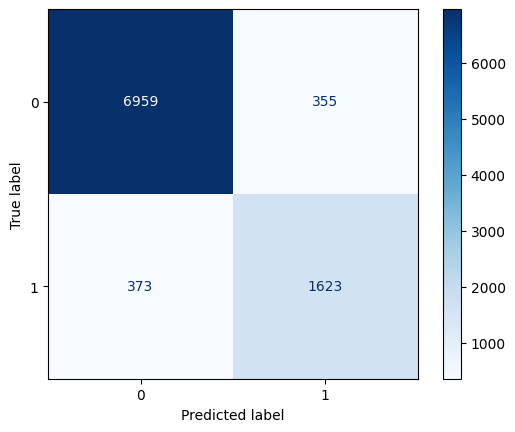

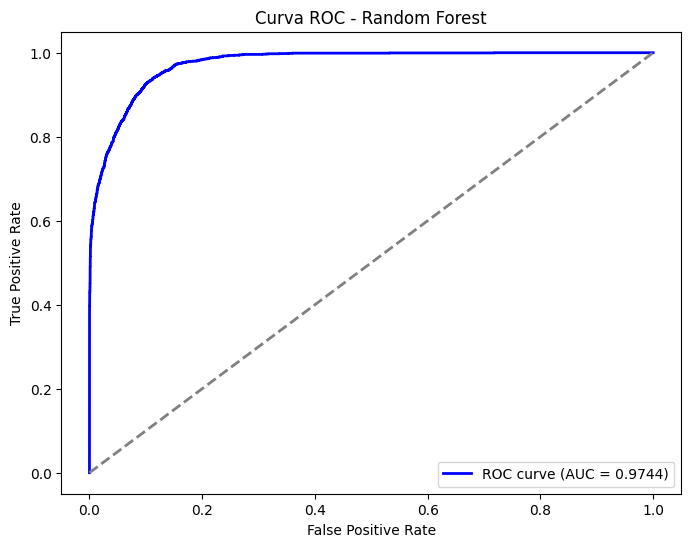

Métricas guardadas en /workspaces/deteccion_clientes_banco/models/resultados/metrics.csv


2025/09/25 23:26:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [23:26:53] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/09/25 23:26:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://0.0.0.0:5000/#/experiments/4/runs/61e1a7caa7894dc0b0147b08e4f9f62d
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/4


In [37]:
parametros, metricas, modelo = entrenar("XGBoost", df)
mlflow.set_tracking_uri("http://0.0.0.0:5000")
mlflow.set_experiment("Baseline Experiment")
with mlflow.start_run(run_name="XGBoost") as run:
    mlflow.log_params(parametros)
    mlflow.log_metrics(metricas)
    mlflow.xgboost.log_model(modelo, "XGBoost")
    run_id = run.info.run_id  # <-- Aquí obtienes el run_id

Accuracy: 0.9169709989258862
Recall: 0.7920841683366734
Precision: 0.815368746776689
F1: 0.8035578144853875
Overfitting: 0.9391213276760298


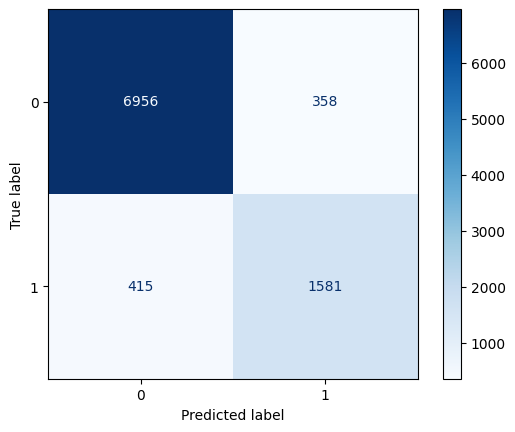

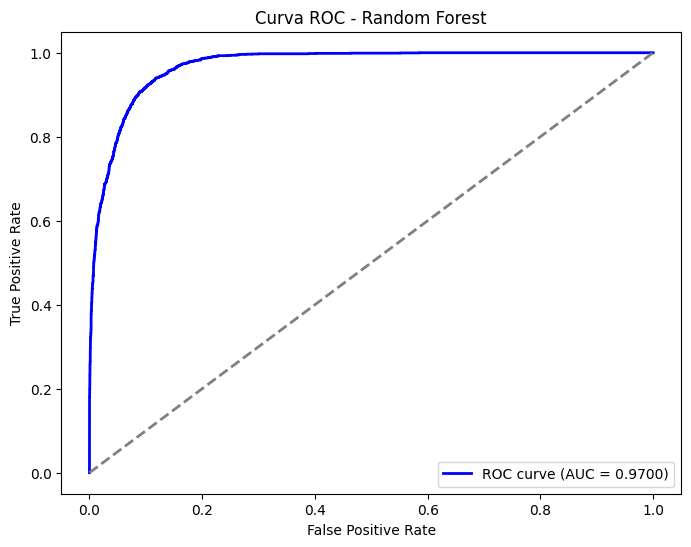

Métricas guardadas en /workspaces/deteccion_clientes_banco/models/resultados/metrics.csv


2025/09/25 21:59:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/25 21:59:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://0.0.0.0:5000/#/experiments/4/runs/93f0c045718c4c1f97f34521466c2440
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/4


In [ ]:
#parametros, metricas, modelo = entrenar("Random Forest", df)
#with mlflow.start_run(run_name='Random Forest'):
    #mlflow.log_params(parametros)
    #mlflow.log_metrics(metricas)
    #mlflow.sklearn.log_model(modelo, "Random Forest")

Accuracy: 0.9129967776584318
Recall: 0.7179358717434869
Precision: 0.8529761904761904
F1: 0.779651795429815
Overfitting: 0.909125087276438


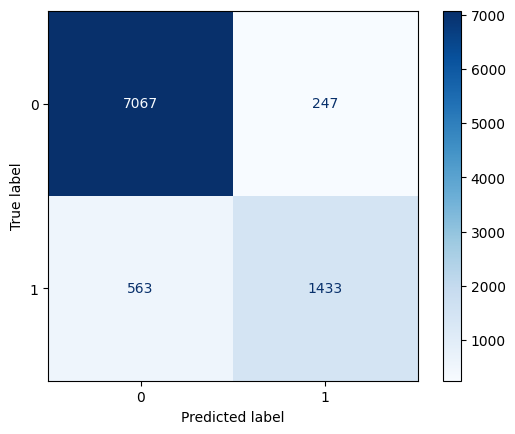

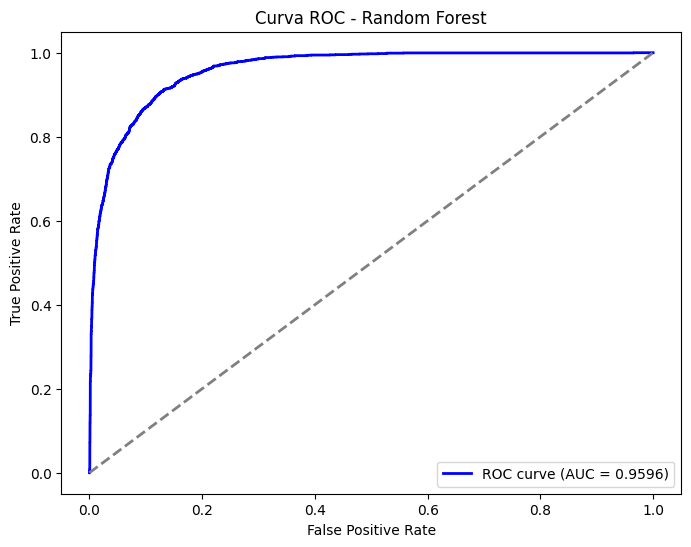

Métricas guardadas en /workspaces/deteccion_clientes_banco/models/resultados/metrics.csv


2025/09/25 21:59:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/09/25 21:59:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Regresión Logística at: http://0.0.0.0:5000/#/experiments/4/runs/a0703a4a14b54de0b00a0102c4c123eb
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/4


In [ ]:
#parametros, metricas, modelo = entrenar("Regresion Logistica", df)
#with mlflow.start_run(run_name='Regresión Logística'):
    #mlflow.log_params(parametros)
    #mlflow.log_metrics(metricas)
    #mlflow.sklearn.log_model(modelo, "Regresion Logistica")
    

In [38]:
client = MlflowClient()
prod_model_name = "client-detection-prod"
model_name = "XGBoost"
model_uri = f"runs:/{run_id}/{model_name}"

# 1. Obtener la última versión en producción
prod_versions = client.get_latest_versions(prod_model_name, stages=["Production"])
if prod_versions:
    prod_model = prod_versions[0]
    prod_run_id = prod_model.run_id
    prod_metrics = client.get_run(prod_run_id).data.metrics
    print("Métricas modelo en producción:", prod_metrics)
else:
    prod_metrics = None
    print("No hay modelo en producción.")

# 2. Obtener métricas del nuevo modelo
# Supón que 'metricas' es el dict de métricas del nuevo modelo
print("Métricas nuevo modelo:", metricas)

# 3. Comparar y decidir si actualizar
if prod_metrics is None or metricas["f1"] > prod_metrics.get("f1", 0):
    print("El nuevo modelo es mejor. Actualizando producción...")
    # Registra el nuevo modelo y lo promueve a producción
    result = mlflow.register_model(model_uri, prod_model_name)
    client.transition_model_version_stage(
        name=prod_model_name,
        version=result.version,
        stage="Production",
        archive_existing_versions=True
    )
else:
    print("El modelo actual en producción es mejor. No se actualiza.")

Métricas modelo en producción: {'accuracy': 0.9254564983888293, 'recall': 0.8136272545090181, 'precision': 0.8345323741007195, 'f1': 0.823947234906139, 'accuracy_train': 0.9423169880229872, 'roc_auc': 0.9763716659460567}
Métricas nuevo modelo: {'accuracy': 0.9218045112781955, 'recall': 0.81312625250501, 'precision': 0.820525783619818, 'f1': 0.8168092601912431, 'accuracy_train': 1.0, 'roc_auc': 0.9744101958360254}
El modelo actual en producción es mejor. No se actualiza.


/tmp/ipykernel_11554/249639945.py:7: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  prod_versions = client.get_latest_versions(prod_model_name, stages=["Production"])


In [25]:
model_name = "XGBoost"
run_id = "f24b4c3d6d594bb0af131df0cc1e8ba1"
model_uri = f"runs:/{run_id}/{model_name}"

result = mlflow.register_model(model_uri, model_name)

Registered model 'XGBoost' already exists. Creating a new version of this model...
2025/09/25 22:23:36 WARNING mlflow.tracking._model_registry.fluent: Run with id f24b4c3d6d594bb0af131df0cc1e8ba1 has no artifacts at artifact path 'XGBoost', registering model based on models:/m-6a5e9ce9a6f54a17a9e20f795c64f276 instead
2025/09/25 22:23:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost, version 2
Created version '2' of model 'XGBoost'.


In [26]:
dev_model_uri=f"models:/{model_name}@champion"
prod_model = "client-detection-prod"

client = mlflow.MlflowClient()
client.copy_model_version(src_model_uri = dev_model_uri, dst_name = prod_model)

Registered model 'client-detection-prod' already exists. Creating a new version of this model...
Copied version '1' of model 'XGBoost' to version '2' of model 'client-detection-prod'.


<ModelVersion: aliases=[], creation_timestamp=1758839019851, current_stage='None', deployment_job_state=<ModelVersionDeploymentJobState: current_task_name='', job_id='', job_state='DEPLOYMENT_JOB_CONNECTION_STATE_UNSPECIFIED', run_id='', run_state='DEPLOYMENT_JOB_RUN_STATE_UNSPECIFIED'>, description='', last_updated_timestamp=1758839019851, metrics=None, model_id=None, name='client-detection-prod', params=None, run_id='f24b4c3d6d594bb0af131df0cc1e8ba1', run_link='', source='models:/XGBoost/1', status='READY', status_message=None, tags={}, user_id='', version='2'>

### Métricas sin Oversampling (36000, 4000)

Accuracy: 0.91

Recall: 0.39

Precision: 0.69

F1: 0.50

### Métricas con Oversampling (36000, 10000)

Accuracy: 0.91

Recall: 0.78

Precision: 0.81

F1: 0.80